# Anomaly Detection

Bij de use-case anomaly detectie of outlier detectie wordt er op zoek gegaan naar de datapunten die zich niet gedragen zoals de rest van de data. 
De technieken die hierbinnen vallen kunnen gebruikt worden om fraude te detecteren of om structurele defecten in machines te detecteren om preventief onderhoud in te plannen of in medische gegevens om ziektes te detecteren.

Een aparte subset van problemen die binnen dit domein liggen is om hacking of netwerk infiltratie te detecteren.
Hier gaat het vaak om een serie van activiteit die verdacht is ipv van enkele datapunten.

Een aantal van de meest gebruikte technieken zijn:
* isolation forest
* Local Outlier Factor
* One-class SVM
* Neurale netwerken
* Hidden Markov Models
* ...

Anomaly detectie wordt vaak toegepast op ongelabelde data (unsupervised learning) omdat je niet alle zaken die mis kunnen gaan op voorhand kunnen detecteren. 
Het feit dat deze punten ook zeer zeldzaam zijn maakt het ook moeilijk om er een goeie dataset van op te bouwen.

## Isolation Forests

De Isolation Forest techniek is een variant op een random forest.
Dit betekend dat het een ensemble-techniek is gebaseerd op meerdere beslissingsbomen.
In deze techniek wordt de dataset verdeeld door een willekeurige feature te kiezen en deze willekeurig te splitsen tussen het minimum en maximum van de feature.
Dit doe je dan voor elke boom tot elk datapunt alleen zit in een eindknoop.
De lengte van het pad dat gevolgd moet worden in elke boom is dan een maatstaf voor hoe standaard het punt is.
Veel punten die geclusterd zijn worden minder snel gesplitst dan outliers en dus hebben deze een veel langer pad in de boom.
Dus datapunten met kortere paden hebben een grote kans om outliers te zijn.


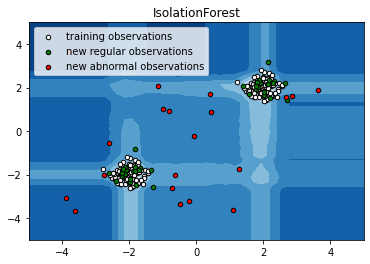

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

# Local Outlier Factor

Dit is een tweede unsupervised outlier detection techniek.
Hierbij worden de dichtste buren gebruikt als maatstaf voor hoe dicht een punt tot de standaard behoort.
Wanneer dit punt een lage afstand heeft is de kans klein dat het een outlier is.

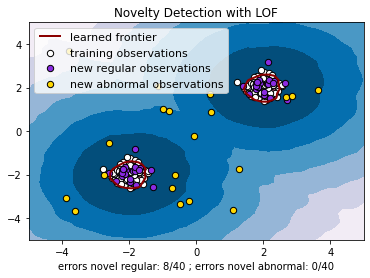

In [10]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers))
plt.show()

# One Class SVM

Standaard SVM zocht naar de beste splitsing tussen twee klassen door middel van een hyperplane dat de marge tussen de klassen zo groot mogelijk maakte.
Bij outlier detection is er echter niet geweten welke punten outliers zijn (unsupervised) dus kan het ook niet gebruikt worden om een scheidingslijn te bepalen.
One-class SVM is echter een uitbreiding op de standaard SVM maar er wordt gezocht naar een hypersfeer dat alle datapunten omvat. 
De grootste marge in de context van SMV kan bij de one-class variant geinterpreteerd worden als de kleinst mogelijke hypersfeer.

De volgende opmerkingen van standaard SVM gelden nog steeds bij one-class svm:
* De marge van de hypersfeer raakt een klein aantal datapunten. Deze worden nog steeds de support-vectors genoemd.
* Het is mogelijk om toe te laten dat een aantal punten buiten de sfeer vallen om zo de detectie minder gevoelig voor ruis te maken
* Er kan gebruik gemaakt worden van een kernel om de grens complexer te maken dan mogelijk is met de originele features.

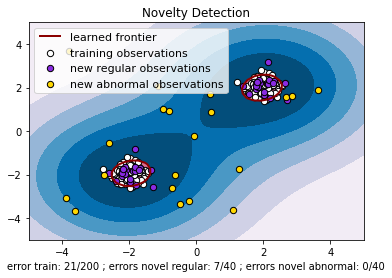

In [11]:
from sklearn.svm import OneClassSVM

# fit the model
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()